# Tennis

---

Created by Jesper Højmark Esbensen, 2018-12-01.

This note book will create and train two agents to play tennis in the Unity Machine Learning environment "Tennis". The solution is based on the general deep reenforcement learning agent supplied in the cource [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

<img src="Tennis.png",width=750>

The environment consists of two "Tennis" rackets moved by an agent in the Unity environemnt. The rewards are setup to give +0.1 hitting the ball and -0.01 for dropping the ball on the floor. As both agents will try to maximizise thier rewards they will end up playing together for as long as possible.

This and a number of other environments from Unity can be found here. [Unity environments](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher).


### 1. Installation instructions

Installation instructions can be found in the readme.md file in the github repository: https://github.com/JesperEsbensen/drlnd_collaboration_and_competition_project



### 2. This solution

The solution in this note book is heavely inspired by the solution to the continuous control project that can be found here: https://github.com/JesperEsbensen/drlnd-continuous-control. That was based on the bi-pedal environment given in the repository: https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal

The solution here is modified by having multiple actor-critics network being trained in the tennis environment. Classes where added to handle the networks.


#### Algorithm

The implementation is based on the Deep Deterministic Policy Gradient algorithme described in the paper:

[Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

The algorithm has shown to performe in different simulated environments. It is a continuous algorithm and therefore suitable for the tennis envrionment. 
The algorithm is based on the Deterministic Policy Gradient (DPG) method that is created around an actor-critic setup. To make the algorithm stable it uses a "replay buffer" and "target/local network". To add exploration it introduces noise to calculated actions.



### 3. The code 

#### Imports
This cell handles the imports of the pyTorch and python modules.


In [1]:
# Import Unity for the environment
from unityagents import UnityEnvironment

# Import for file handling.
import os

# Import numpy for the math
import numpy as np

# Import torch for the AI
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# A little extra than standard python.
from collections import namedtuple, deque
import random
import copy

# Time for timing
import time


#### Environment
This cell defines a class for handling a Unity environment. It helps handle the start, close down and the extraction of values.


In [2]:
class Environment ():
    
    # Encapsulates the environment and enables the use of 'with' to handle open/close.
    
    def __init__(self, envFile):
        """Initialize parameters for environment.
        Params
        ======
            envFile (string): Path to envrionment executable
        """
        self.filename = envFile
        self.env = UnityEnvironment(file_name=envFile)
            
        # get the default brain
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]

        # reset the environment
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        
        print ('Created unity enviroment from ', envFile)
        self.dump_key_attributes()
        
    def __enter__(self):
        return self
            
    def state_size(self):
        return self.env_info.vector_observations.shape[1]
        
    def action_size(self):
        return self.brain.vector_action_space_size

    def agent_size(self):
        return len(self.env_info.agents)
    
    def reset(self, train_mode=True):
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        return self.env_info.vector_observations, self.env_info.rewards, self.env_info.local_done

    def step(self, actions):
        self.env_info = self.env.step(actions)[self.brain_name]
        return self.env_info.vector_observations, self.env_info.rewards, self.env_info.local_done

    #def states(self, train_mode=True):
    #    return self.env.reset(train_mode)[self.brain_name]
    
    def dump_key_attributes (self):
        print('Environment     :', self.filename)
        print('Number of agents:', self.agent_size())
        print('State size      :', self.state_size())
        print('Action size     :', self.action_size())
        
    def end():
        self.env.close()

    def __exit__(self, exc_type, exc_value, traceback):
        self.env.close()


#### Utility
An utility function for initializing a layer in a network.

In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

#### Hardware

Detect if a GPU is available.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


#### Actor network

The actor network to determine the actions to take from the given state. 
The network is build up from experiments. The structure is:

* Fully connected layer from 2x24 input state points to 200 hidden nodes.
* A batch normalization layer
* A rectifying liniar activation functions (Relu) layer
* A fully connected layer from the 200 hidden nodes to 100 hidden notes.
* A batch normalization layer
* A relu layer
* A fully connected layer from the 100 hidden nodes to 2 activation outputs
* A tanh activation function to create a action signal beween -1 and 1.

after the actions is calculated a noise can be added to explore the state space. This is generated as a Ornstein-Uhlenbeck process, but reduced over time defined by a decay-rate.


In [5]:
class ActorNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, agent_size, seed, fc1_units=132, fc2_units=132):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size * agent_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(num_features=fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
        print ("Actor net: Input ", state_size * agent_size, "->", fc1_units, \
               "hidden layer ", fc1_units, "->", fc2_units, \
               "output layer ", fc2_units, "->", action_size)

    def reset_parameters(self):
        f,t = hidden_init(self.fc1)
        self.fc1.weight.data.uniform_(f,t)
        f,t = hidden_init(self.fc2)
        self.fc2.weight.data.uniform_(f,t)
        self.fc3.weight.data.uniform_(-3e-3,3e-3)

    def forward(self, state):
        
        """Build an actor (policy) network that maps states -> actions."""
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)        
        x = self.fc3(x)
        x = torch.tanh(x)

        return x
    

class Actor ():
    
    def __init__(self, state_size, action_size, seed, fc1_units=300, fc2_units=150, device='cpu'):
        
        # Actor Network (w/ Target Network)
        self.local = ActorNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.target = ActorNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=LR_ACTOR)

        self.noise_gen = OUNoise(action_size, random_seed, theta=NOISE_THETA , sigma=NOISE_SIGMA)
        #self.noise_gen = AltNoise(action_size, random_seed, level=0.5)        
        self.noise_sizes = deque(maxlen=50)
        self.action_sizes = deque(maxlen=50)
        self.noise_decay = NOISE_DECAY
        
    def soft_update(self, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(self.target.parameters(), self.local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
    def act(self, state, add_noise ):
        
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        
        # Set network to evaluation mode
        self.local.eval()
        with torch.no_grad():
            action = self.local(state).cpu().data.numpy()

        # Set network to training mode.
        self.local.train()
        
        noise = 0.0
        if add_noise:
            noise = self.noise_gen.sample(action)
            action += noise * self.noise_decay
            
        self.action_sizes.append(float(np.linalg.norm(action)))
        self.noise_sizes.append(float(np.linalg.norm(noise)))
            
        # Make the noisy action look like the original action.
        return action
    
    def new_episode (self):
        self.noise_gen.reset()
        self.noise_decay = self.noise_decay * NOISE_DECAY
        
    def noiserate(self):
        self.noise_rate = np.mean(self.noise_sizes)/np.mean(self.action_sizes)       
        return self.noise_rate
    
    def load (self, filename):
        self.local.load_state_dict(torch.load(filename + '-actor-local.pth'))
        self.target.load_state_dict(torch.load(filename + '-actor-target.pth'))
        
    def save (self, filename):
        torch.save(self.local.state_dict(), filename + '-actor-local.pth')
        torch.save(self.target.state_dict(), filename + '-actor-target.pth')
    

#### Critic network

The critic network to estimate the value of taking an action - the reward. 
The network is build up from experiments. The structure is:

* Fully connected layer from 2x24 input state points to 300 hidden nodes.
* A batch normalization layer
* A rectifying liniar activation functions (Relu) layer
* The output here is concatenated with the actions to evaluate. Into a 300 + 2*2 hidden layer.
* A fully connected layer from 304 hidden notes to 150 hidden nodes.
* A batch normalization layer
* A relu layer
* A fully connected layer from the 150 hidden nodes to 1 value



In [6]:
class CriticNetwork (nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, agent_size, seed, fc1_units=300, fc2_units=150):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size * agent_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size * agent_size, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        print ("Critic net: Input ", state_size * agent_size, "->", fc1_units, \
               "hidden layer + actions", fc1_units, " + ", action_size * agent_size, "->", fc2_units, \
               "hidden layer ", fc2_units, "-> output ", 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        f,t = hidden_init(self.fc1)
        self.fc1.weight.data.uniform_(f,t)
        f,t = hidden_init(self.fc2)
        self.fc2.weight.data.uniform_(f,t)
        self.fc3.weight.data.uniform_(-3e-3,3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = torch.cat((x, action), dim=1)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
class Critic ():
    
    def __init__(self, state_size, action_size, agent_size, seed, fc1_units=100, fc2_units=50, device='cpu'):
        
        # Critic Network (w/ Target Network)
        print ("state size:", state_size, "action size:", action_size, "fc1:", fc1_units, "fc2_units:", fc2_units)
        self.local = CriticNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.target = CriticNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
    def soft_update(self, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(self.target.parameters(), self.local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    def load (self, filename):
        self.local.load_state_dict(torch.load(filename + '-critic-local.pth'))
        self.target.load_state_dict(torch.load(filename + '-critic-target.pth'))
        
    def save (self, filename):
        torch.save(self.local.state_dict(), filename + '-critic-local.pth')
        torch.save(self.target.state_dict(), filename + '-critic-target.pth')


#### The Agent

The agent handles the networks: actor, critic and thier target and local versions. It handles the noice generator, the replay buffer, the act and learn steps.
Note that a decay rate of the noice has been build in. This way the noise is higher in the beginning and becomes lower with the number of steps taken.

In [7]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, index, environment, actor, critic, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.env = environment
        
        self.index = index
        self.state_size = self.env.state_size()
        self.action_size = self.env.action_size()
        self.agent_size = self.env.agent_size()
        self.seed = random.seed(random_seed)
        self.step_counter = 0

        # Actor Network (w/ Target Network)   
        self.actor = actor

        # Critic Network (w/ Target Network)
        self.critic = critic

        # Replay memory
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        print ('Created agent: states = ', self.state_size, ' actions = ', self.action_size)

    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.step_counter += 1
        
        # Save experience / reward.
        self.memory.add(state, action, reward, next_state, done)
        # ("step", state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.step_counter % 1 == 0:
            for _ in range(5):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

                
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        actions = self.actor.act(state, add_noise)
        #print ('Actions:', actions, 'States:', state)
        return actions  # np.clip(actions, -1, 1)
    

    def new_episode(self):
        self.actor.new_episode()
            
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor.target(next_states)
        
        if self.index == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)

        #actions_next = torch.cat((actions_next, actions_prev), dim=1)
        Q_targets_next = self.critic.target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic.local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()

            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor.local(states)
        
        if self.index == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        #actions_next = torch.cat((actions_pred, actions), dim=1)
        actor_loss = -self.critic.local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
            
        # ----------------------- update target networks ----------------------- #
        self.critic.soft_update(TAU)
        self.actor.soft_update(TAU)     

            
    def environment(self):
        return self.env
           
    def noise_rate(self):
        return self.actor.noiserate()
    
    def load (self, filename):
        self.actor.load(filename)
        self.critic.load(filename)
        
    def save (self, filename):
        self.actor.save(filename)
        self.critic.save(filename)
    

#### Noise

Noise is introduced to the actions generated to enabled the network to explore "alternative" actions.
Note that the Ornenstein-Uhlenbeck is modified to give negaive random numbers as well.

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.noise_decay = NOISE_DECAY
        self.size = size
        self.reset()


    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        self.noise_decay = max (self.noise_decay * NOISE_DECAY, NOISE_MIN)

    def sample(self, action):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() - 0.5)*2 for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx

        return self.state * self.noise_decay
    
class AltNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, level=0.1):
        """Initialize parameters and noise process."""
        self.seed = random.seed(seed)
        self.noise_decay = NOISE_DECAY
        self.level = level
        
    def sample(self, action):
        """Update internal state and return it as a noise sample."""
        al = np.linalg.norm(action)
        no = np.array([(random.random() - 0.5)*2*self.level*al for i in range(len(action))])
        
        return no * self.noise_decay
    
    def reset(self):
        self.noise_decay = max (self.noise_decay * NOISE_DECAY, NOISE_MIN)
        return

#### Replay buffer

The replay buffer is a buffer where tuples of stats, action, rewards are stored. They can in random order be sampled and used  in the learning process. By selecting the steps the correlation between steps is broken.



In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, reward_level=-1.0):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): action size
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (): For random generation and initilization of the noise generator.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # Internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.rf = 0
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        
        # We add all actions that gave a success, and only some that dident.
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    

#### Main loop

The main loop drives the process of having the agent act in the environment.
Loop episodes and timesteps to drive the environment, agent and learning.

When the goal is reached the process will continue for another 25% episodes to see what happens. A loop will start from a set of actor/critics files if they exist. A set of actor and critics network is stored every time a better result is reached and a separate set when the goal is reached.

In addition to the average score this the main loop will display:
* reward fraction - number of actions with success of all of the stored actions (for the experiment)
* Noice level - vector length of noise added compared to action vector.
* Time - loop time of episode.

For every episode, if a better result has been achieved, the parameters are stored. When the goal is reached the parameters are also stored - and kept.

In [10]:
def ddpg(name, environment, agents, n_episodes=2000, max_t=10000, print_every=100, goal=0.5, reuseNetwork=False, mode='train'):
    
    checkpointfile = name + '-agent1-best-actor-local.pth'
    if reuseNetwork:
        if os.path.isfile(checkpointfile):
            print('\nLoading checkpoints:', checkpointfile)
            agents[0].load(name + '-agent1-best')
            agents[1].load(name + '-agent2-best')
        else:
            print('\nRestart learning - no checkpoint file found:', checkpointfile)
    else:
        print('\nStarting with a freshly initialized network.')        
        
    scores_deque = deque(maxlen=print_every)
    scores = []
    scores_sliding = []
    best_score = 0
    goal_passed = 0
    goal_passed_counter = 0
    
    # Drive episodes.
    for i_episode in range(1, n_episodes+1):
        
        start = time.time()

        states, rewards, dones = environment.reset()
        state = np.reshape(states, (1, env.state_size() * len(agents)))
        
        score_agents = np.zeros(env.agent_size())
        
        agents[0].new_episode()
        agents[1].new_episode()

        for t in range(max_t):
            
            # Calculate best actions for this step. 
            action1 = agents[0].act( state, mode == 'train' )
            action2 = agents[1].act( state, mode == 'train' )

            actions = np.concatenate((action1, action2), axis=0) 
            actions = np.reshape(actions, (1, env.action_size() * len(agents)))
            
            # Determin next state.
            next_states, rewards, dones = environment.step( actions )  # send the action to the environment
            next_state = np.reshape(next_states, (1, env.state_size() * len(agents)))
            
            # Agent takes step and learns.
            if mode == 'train':
                agents[0].step(state, actions, rewards[0], next_state, dones[0])
                agents[1].step(state, actions, rewards[1], next_state, dones[1])
                
            # Prepare next loop.
            states = next_states
            state = next_state
            score_agents += rewards
            
            if np.any(dones):
                break 
                
            if not mode == 'train':
                time.sleep(0.1)
        
        score = np.max(score_agents)
        scores_deque.append(score)
        scores.append(score)
        
        score_average = np.mean(scores_deque)
        scores_sliding.append(score_average)
        
        end = time.time()
        
        # Only print results if we are training.
        if mode == 'train':
            # Store model parameters if it is better than the last best.
            if score_average > best_score:
                best_score = score_average
                agents[0].save( name + '-agent1-best')
                agents[1].save( name + '-agent2-best')

                print('\rEpisode {}, Average Score: {:.3f}, ({:.3f}/{:.3f}), Noise rate {:.3f}, Time {:.2f}. Better model.'.format( \
                    i_episode, np.mean(scores_deque), rewards[0], rewards[1], agents[0].noise_rate(), \
                    end - start))
            else:
                print('\rEpisode {}, Average Score: {:.6f}, ({:.3f}/{:.3f}), Noise rate {:.3f}, Time {:.2f}.'.format( \
                    i_episode, np.mean(scores_deque), rewards[0], rewards[1], agents[0].noise_rate(), \
                    end - start), end="" )

            if i_episode % print_every == 0:
                print('\rEpisode {}, Average Score: {:.3f}, ({:.3f}/{:.3f}), Noise rate {:.3f}, Time {:.2f}.'.format( \
                    i_episode, np.mean(scores_deque), rewards[0], rewards[1], agents[0].noise_rate(), \
                    end - start))
                print ("Actions ", action1, action2)

            if score_average >= goal:
                if goal_passed == 0:
                    goal_passed = i_episode

                    print('\nGoal reached in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, score_average))
                    agents[0].save( name + '-agent1-goal')
                    agents[1].save( name + '-agent2-goal')

            if goal_passed > 0:
                goal_passed_counter = goal_passed_counter + 1

            if goal_passed > 0 and goal_passed_counter > goal_passed * 0.2: # Run addtional 20% episodes to see what happens.
                break
        else:
            # Wait for 3 seconds before playing next episode
            time.sleep(3)
            
    return scores, scores_sliding


#### Plotting

Below you find two functions for plotting the scores collected. For one timeseries and for comparing two timeseries.

In [11]:
import matplotlib.pyplot as plt

def plotScores (scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [12]:
import matplotlib.pyplot as plt

def plotCompareScores (score1, score2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(score1)+1), score1)
    plt.plot(np.arange(1, len(score2)+1), score2)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Execution

#### Test the reward level experiment
The two networks are executet and compared to see what effect the reward level experiment has.


In [13]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 7.5e-2            # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.00     # L2 weight decay
NOISE_SIGMA = 1.00      # Ornstein-Uhlenbeck parameter
NOISE_THETA = 1.00      # Ornstein-Uhlenbeck parameter
NOISE_DECAY = 0.99      # Decay rate per episode for the noise
NOISE_MIN   = 0.0001    # Ensure a minumum noise.

with Environment (envFile='.\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe') as env:    
    
    random_seed = 2
    
    # Build the agent
    actor1 = Actor(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    actor2 = Actor(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)  
    
    critic1 = Critic(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    critic2 = Critic(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    
    agents = [
        Agent( 0, env, actor1, critic1, random_seed=2 ),
        Agent( 1, env, actor2, critic2, random_seed=2 )
    ]
        
    # Train the agent.
    scores, sliding = ddpg ( 'Tennis', env, agents, goal=0.5, n_episodes=2000)
    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Created unity enviroment from  .\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe
Environment     : .\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe
Number of agents: 2
State size      : 24
Action size     : 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
state size: 24 action size: 2 fc1: 100 fc2_units: 50
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
state size: 24 action size: 2 fc1: 100 fc2_units: 50
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidde

Episode 1065, Average Score: 0.206, (0.000/-0.010), Noise rate 0.000, Time 117.21. Better model.
Episode 1066, Average Score: 0.208, (0.000/-0.010), Noise rate 0.000, Time 17.98. Better model.
Episode 1067, Average Score: 0.210, (-0.010/0.000), Noise rate 0.000, Time 28.73. Better model.
Episode 1068, Average Score: 0.212, (0.000/-0.010), Noise rate 0.000, Time 24.73. Better model.
Episode 1069, Average Score: 0.214, (-0.010/0.000), Noise rate 0.000, Time 32.70. Better model.
Episode 1070, Average Score: 0.216, (0.000/-0.010), Noise rate 0.000, Time 26.13. Better model.
Episode 1074, Average Score: 0.220, (0.000/-0.010), Noise rate 0.000, Time 62.28. Better model.
Episode 1075, Average Score: 0.222, (-0.010/0.000), Noise rate 0.000, Time 13.45. Better model.
Episode 1076, Average Score: 0.224, (0.000/-0.010), Noise rate 0.000, Time 21.38. Better model.
Episode 1077, Average Score: 0.225, (-0.010/0.000), Noise rate 0.000, Time 20.80. Better model.
Episode 1079, Average Score: 0.233, (-0

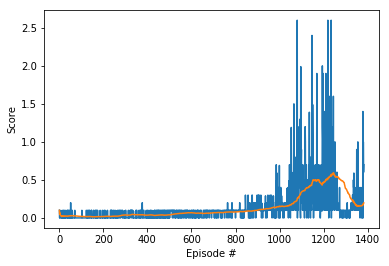

In [14]:
plotCompareScores (scores, sliding)

The goal was reached in 1152  episodes, and it reached almost 0.6 in before breaking down. 


### Play a game

Take the best network play a game.

In [15]:

with Environment (envFile='.\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe') as env:    
    
    random_seed = 2
    
    # Build the agent
    actor1 = Actor(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    actor2 = Actor(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)  
    
    critic1 = Critic(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    critic2 = Critic(env.state_size(), env.action_size(), env.agent_size(), random_seed, device=device)
    
    agents = [
        Agent( 0, env, actor1, critic1, random_seed=2 ),
        Agent( 1, env, actor2, critic2, random_seed=2 )
    ]
        
    # Train the agent.
    scores, sliding = ddpg ( 'Tennis', env, agents, goal=0.5, n_episodes=5, reuseNetwork=True, mode='play'  )
    


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Created unity enviroment from  .\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe
Environment     : .\Tennis_Windows_x86_64\Tennis_Windows_x86_64\Tennis.exe
Number of agents: 2
State size      : 24
Action size     : 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
Actor net: Input  48 -> 150 hidden layer  150 -> 132 output layer  132 -> 2
state size: 24 action size: 2 fc1: 100 fc2_units: 50
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
state size: 24 action size: 2 fc1: 100 fc2_units: 50
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidden layer  150 -> output  1
Critic net: Input  48 -> 50 hidden layer + actions 50  +  4 -> 150 hidde

### 3. Conclusion

It is possible to create a deep reinforcement learning network that can play tennis in the Unity environment. It is very important to be very precise in the design and programming of the network. Small errors are sometimes compensated partly by the flexibility of the network and there fore difficult to identify as errors. Also designs and choice of hyper parameters that seem intuitive have the opposite influence than expected. 

It is important to have a focus on timing the algorithems. The learning cycle for the developper is increased greatly by the long learning sessions that are needed by the network.

Printing out state, actions, noise levels, etc is and important way to get visibility into the calculations done and identify a breakdown or an error in the system.



### 4. Future improvements

Future improvements could be:
* Automation of hyper parameter finding. Ex: grid search.
* Futher fine tuning of the hyper parameters. 
* Try out other deep reinforcement learning algorithmes like PPO
* Investigate why the network seems to unlearn and degenerate completely at some point.
* It would be interesting to see how different designs for critic (centrelized or individual) would influence the learning.


